# Homework 3
## INF 552: Machine Learning for Data Informatics 
### Jungho Choi (junghoch@usc.edu) 

1.Time Series Classification

An interesting task in machine learning is classification of time series. In this problem,
we will classify the activities of humans based on time series obtained by a Wireless
Sensor Network.

(a) Download the AReM data from: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+%28AReM%29. The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.



In [187]:
%matplotlib inline
import numpy as np
import pandas as pd
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats
import seaborn as sb
import matplotlib.pyplot as plt
from os.path import join
#import statsmodels.discrete.discrete_model as sm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import shuffle
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import warnings
warnings.filterwarnings('ignore')

(b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [2]:
activities = ['bending1','bending2','cycling','lying','sitting','standing','walking']
datasetsNums = pd.Series([7, 6, 15, 15, 15, 15, 15], index=activities)

train_data2 = []
test_data2 = []

for a in activities:
    for i in range(1, datasetsNums[a] + 1):
        data_path = join("AReM", a, "dataset"+str(i)+".csv")
        df = pd.read_csv(data_path,header=None, skiprows=range(0,5), delimiter=",|\s+",engine='python')
        if(i <= 2):
            test_data2.append((df, a))
        elif(a != 'bending1' and a != 'bending2' and i == 3):
            test_data2.append((df, a))
        else:
            train_data2.append((df, a))

(c) Feature Extraction

Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.

i. Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc).

- In time series classification, minimum, maximum, mean, median, standard deviation, 25% (first quartile) and 75% (third quartile) are used 

ii. Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them
directly.

In [3]:
datasets = test_data2 + train_data2

newDataset = []
for ds in datasets:
    df = ds[0]
    stats = df.describe()
    stats = stats.loc[['min','max','mean','50%','std','25%','75%']]
    row = pd.Series()
    for i in range(1, 7):
        row['min'+str(i)] = stats.iloc[0,i]
        row['max'+str(i)] = stats.iloc[1,i]
        row['mean'+str(i)] = stats.iloc[2,i]
        row['median'+str(i)] = stats.iloc[3,i]
        row['std'+str(i)] = stats.iloc[4,i]
        row['1st_quart'+str(i)] = stats.iloc[5,i]
        row['3rd_quart'+str(i)] = stats.iloc[6,i]
    row['activity'] = ds[1]
    newDataset.append(row)
    
newData = pd.DataFrame(newDataset)
newData

min1   max1      mean1  median1      std1  1st_quart1  3rd_quart1  min2  \
0   37.25  45.00  40.624792   40.500  1.476967     39.2500     42.0000   0.0   
1   38.00  45.67  42.812812   42.500  1.435550     42.0000     43.6700   0.0   
2   12.75  51.00  24.562958   24.250  3.737514     23.1875     26.5000   0.0   
3    0.00  42.75  27.464604   28.000  3.583582     25.5000     30.0000   0.0   
4   24.25  45.00  37.177042   36.250  3.581301     34.5000     40.2500   0.0   
5   28.75  44.75  37.561187   36.875  3.226507     35.2500     40.2500   0.0   
6   22.00  44.67  37.058708   36.000  3.710180     34.5000     40.0625   0.0   
7   23.50  30.00  27.716375   27.500  1.442253     27.0000     29.0000   0.0   
8   24.75  48.33  44.182937   48.000  7.495615     48.0000     48.0000   0.0   
9   48.00  48.25  48.004167   48.000  0.032038     48.0000     48.0000   0.0   
10  33.25  48.00  42.363563   43.000  2.068247     42.0000     43.5000   0.0   
11  37.00  50.75  45.917667   45.635  1.089027     45.0000     46.5000   0.0   
12  44.50  46.75  45.239667   45.000  0.429915     45.0000     45.3300   0.0   
13  33.33  48.00  44.334729   45.000  2.476940     42.2500     46.5000   0.0   
14  35.50  46.25  43.174938   43.670  1.989052     42.5000     44.5000   0.0   
15  32.75  47.00  42.760562   44.500  3.398919     41.3300     45.3725   0.0   
16  19.33  43.50  34.227771   35.500  4.889576     30.5000     37.7500   0.0   
17  12.50  45.00  33.509729   34.125  4.850923     30.5000     36.7500   0.0   
18  15.00  46.75  34.660583   35.000  5.315110     31.0000     38.2500   0.0   
19  35.00  47.40  43.954500   44.330  1.558835     43.0000     45.0000   0.0   
20  33.00  47.75  42.179812   43.500  3.670666     39.1500     45.0000   0.0   
21  33.00  45.75  41.678063   41.750  2.243490     41.3300     42.7500   0.0   
22  37.00  48.00  43.454958   43.250  1.386098     42.5000     45.0000   0.0   
23  36.25  48.00  43.969125   44.500  1.618364     43.3100     44.6700   0.0   
24  21.00  50.00  32.586208   33.000  6.238143     26.1875     34.5000   0.0   
25  27.50  33.00  29.881938   30.000  1.153837     29.0000     30.2700   0.0   
26  19.00  45.50  30.938104   29.000  7.684146     26.7500     38.0000   0.0   
27  25.00  47.50  31.058250   29.710  4.829794     27.5000     31.8125   0.0   
28  19.00  44.00  36.228396   36.000  3.528617     34.0000     39.0000   0.0   
29  26.50  44.33  36.687292   36.000  3.529404     34.2500     39.3725   0.0   
..    ...    ...        ...      ...       ...         ...         ...   ...   
58  35.25  48.50  40.219271   39.250  2.741217     37.7500     42.5000   0.0   
59  28.50  48.25  43.884833   45.250  3.198894     42.0000     46.5000   0.0   
60  39.50  45.00  42.111583   42.000  1.122245     41.5000     42.0000   0.0   
61  39.67  44.75  42.282667   41.500  1.356149     41.5000     44.3300   0.0   
62  40.00  44.67  42.360188   42.000  1.017372     41.5000     43.2500   0.0   
63  29.25  46.00  42.728854   43.250  2.046362     41.3300     44.5000   0.0   
64  30.00  46.67  42.648521   42.750  2.395338     41.5000     45.0000   0.0   
65  36.00  47.50  43.720021   45.000  2.384105     43.0000     45.0000   0.0   
66  34.50  47.75  44.471146   45.000  1.772553     45.0000     45.2500   0.0   
67  35.50  48.00  46.224938   46.000  1.748315     45.2500     48.0000   0.0   
68  29.75  48.00  46.932208   47.500  1.832665     47.2375     47.7500   0.0   
69  36.33  47.67  45.399625   45.500  1.328121     45.0000     46.3300   0.0   
70  36.00  45.80  42.419917   42.670  2.520129     41.3300     44.6175   0.0   
71  37.00  48.25  42.516958   42.500  2.195751     41.0000     44.5000   0.0   
72  36.25  45.50  42.959354   42.670  1.500878     42.0000     44.3300   0.0   
73  36.00  47.33  42.674583   43.670  2.384170     40.0000     44.7500   0.0   
74  36.25  45.75  43.187521   44.750  2.491162     39.7500     45.0000   0.0   
75  36.00  47.33  44.441187   45.000  2.417797     44.6275     45.7500   0.0   
76  1

iii. Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [4]:
for i in range(42):
    std_result = bs.bootstrap(newData.iloc[:,i].values, stat_func=bs_stats.std, alpha=0.1)
    print(str(newData.columns[i])+":")
    print(std_result)

min1:
9.51544506693    (8.30286417483, 10.824720797)
max1:
4.36932238296    (3.46692613258, 5.39648075987)
mean1:
5.30531446124    (4.75993470559, 5.9268520532)
median1:
5.40905642536    (4.85017415885, 6.0444824062)
std1:
1.76205557515    (1.58521086212, 1.96037336101)
1st_quart1:
6.11852624945    (5.62742484448, 6.69789129805)
3rd_quart1:
5.10964275337    (4.40143507527, 5.91289273962)
min2:
0.0    (0.0, 0.0)
max2:
5.03388167916    (4.69355720248, 5.46369120386)
mean2:
1.56519425207    (1.43213403269, 1.74557193256)
median2:
1.40419712417    (1.27064663526, 1.58058461908)
std2:
0.879067799127    (0.821818628233, 0.961921510875)
1st_quart2:
0.94099363332    (0.851615565011, 1.05453907651)
3rd_quart2:
2.11315652774    (1.94410681267, 2.3426016996)
min3:
2.93961598442    (2.78628279531, 3.13797792802)
max3:
4.84735791117    (4.26556652731, 5.53775149064)
mean3:
3.98554017303    (3.51211729581, 4.56555796803)
median3:
4.01339672234    (3.50992572246, 4.62479142965)
std3:
0.941315857697  

iv. Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).

- Min, mean, max seems to be the most important time-domain features

(d) Binary Classification Using Logistic Regression

i. Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classification problem. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

In [38]:
newtrain = []
for ds in train_data2:
    df = ds[0]
    stats = df.describe()
    stats = stats.loc[['min','max','mean','50%','std','25%','75%']]
    row = pd.Series()
    for i in range(1, 7):
        row['min'+str(i)] = stats.iloc[0,i]
        row['max'+str(i)] = stats.iloc[1,i]
        row['mean'+str(i)] = stats.iloc[2,i]
        row['median'+str(i)] = stats.iloc[3,i]
        row['std'+str(i)] = stats.iloc[4,i]
        row['1st_quart'+str(i)] = stats.iloc[5,i]
        row['3rd_quart'+str(i)] = stats.iloc[6,i]
    row['activity'] = ds[1]
    newtrain.append(row)
    
newtrain = pd.DataFrame(newtrain)
newtrain

min1   max1      mean1  median1      std1  1st_quart1  3rd_quart1  min2  \
0   35.00  47.40  43.954500   44.330  1.558835     43.0000     45.0000   0.0   
1   33.00  47.75  42.179812   43.500  3.670666     39.1500     45.0000   0.0   
2   33.00  45.75  41.678063   41.750  2.243490     41.3300     42.7500   0.0   
3   37.00  48.00  43.454958   43.250  1.386098     42.5000     45.0000   0.0   
4   36.25  48.00  43.969125   44.500  1.618364     43.3100     44.6700   0.0   
5   21.00  50.00  32.586208   33.000  6.238143     26.1875     34.5000   0.0   
6   27.50  33.00  29.881938   30.000  1.153837     29.0000     30.2700   0.0   
7   19.00  45.50  30.938104   29.000  7.684146     26.7500     38.0000   0.0   
8   25.00  47.50  31.058250   29.710  4.829794     27.5000     31.8125   0.0   
9   19.00  44.00  36.228396   36.000  3.528617     34.0000     39.0000   0.0   
10  26.50  44.33  36.687292   36.000  3.529404     34.2500     39.3725   0.0   
11  25.33  45.00  37.114313   36.250  3.710385     34.5000     40.2500   0.0   
12  26.75  44.75  36.863375   36.330  3.555787     34.5000     39.7500   0.0   
13  26.25  44.25  36.957458   36.290  3.434863     34.5000     40.2500   0.0   
14  27.75  44.67  37.144833   36.330  3.758904     34.0000     40.5000   0.0   
15  27.00  45.00  36.819521   36.000  3.900459     33.7500     40.2500   0.0   
16  27.00  44.33  36.541667   36.000  4.018922     33.2500     39.8125   0.0   
17  18.50  44.25  35.752354   36.000  4.614802     33.0000     39.3300   0.0   
18  19.00  43.75  35.879875   36.000  4.614878     33.0000     39.5000   0.0   
19  23.33  43.50  36.244083   36.750  3.822016     33.4575     39.2500   0.0   
20  24.25  45.00  37.177042   36.250  3.581301     34.5000     40.2500   0.0   
21  34.00  51.00  42.706063   40.500  3.537476     40.2500     48.0000   0.0   
22  39.00  41.00  39.667833   39.500  0.280158     39.5000     39.7500   0.0   
23   0.00  40.67  39.506188   39.500  1.817498     39.5000     39.6700   0.0   
24  39.00  40.00  39.433792   39.500  0.208558     39.3300     39.5000   0.0   
25  39.00  40.00  39.347104   39.330  0.231405     39.2500     39.5000   0.0   
26  39.00  56.25  47.325125   42.670  5.961280     42.0000     54.0000   0.0   
27  23.50  30.00  27.716375   27.500  1.442253     27.0000     29.0000   0.0   
28  48.00  48.25  48.004167   48.000  0.032038     48.0000     48.0000   0.0   
29  39.00  41.00  39.667833   39.500  0.280158     39.5000     39.7500   0.0   
..    ...    ...        ...      ...       ...         ...         ...   ...   
39  35.25  48.50  40.219271   39.250  2.741217     37.7500     42.5000   0.0   
40  28.50  48.25  43.884833   45.250  3.198894     42.0000     46.5000   0.0   
41  39.50  45.00  42.111583   42.000  1.122245     41.5000     42.0000   0.0   
42  39.67  44.75  42.282667   41.500  1.356149     41.5000     44.3300   0.0   
43  40.00  44.67  42.360188   42.000  1.017372     41.5000     43.2500   0.0   
44  29.25  46.00  42.728854   43.250  2.046362     41.3300     44.5000   0.0   
45  30.00  46.67  42.648521   42.750  2.395338     41.5000     45.0000   0.0   
46  36.00  47.50  43.720021   45.000  2.384105     43.0000     45.0000   0.0   
47  34.50  47.75  44.471146   45.000  1.772553     45.0000     45.2500   0.0   
48  35.50  48.00  46.224938   46.000  1.748315     45.2500     48.0000   0.0   
49  29.75  48.00  46.932208   47.500  1.832665     47.2375     47.7500   0.0   
50  36.33  47.67  45.399625   45.500  1.328121     45.0000     46.3300   0.0   
51  36.00  45.80  42.419917   42.670  2.520129     41.3300     44.6175   0.0   
52  37.00  48.25  42.516958   42.500  2.195751     41.0000     44.5000   0.0   
53  36.25  45.50  42.959354   42.670  1.500878     42.0000     44.3300   0.0   
54  36.00  47.33  42.674583   43.670  2.384170     40.0000     44.7500   0.0   
55  36.25  45.75  43.187521   44.750  2.491162     39.7500     45.0000   0.0   
56  36.00  47.33  44.441187   45.000  2.417797     44.6275     45.7500   0.0   
57  1

In [39]:
newData = newtrain

bending1 = newData.loc[newData['activity'] == 'bending1']
bending2 = newData.loc[newData['activity'] == 'bending2']

cycling = newData.loc[newData['activity'] == 'cycling']
lying = newData.loc[newData['activity'] == 'lying']
sitting = newData.loc[newData['activity'] == 'sitting']
standing = newData.loc[newData['activity'] == 'standing']
walking = newData.loc[newData['activity'] == 'walking']

bending_all = bending1.append(bending2)
#cycling + lying + sitting + standing + walking
etc = cycling.append(lying)
etc = etc.append(sitting)
etc = etc.append(standing)
etc = etc.append(walking)

# Time Series 1
min1_bending = list(bending_all['min1'])
min1_etc = list(etc['min1'])

max1_bending = list(bending_all['max1'])
max1_etc = list(etc['max1'])    

mean1_bending = list(bending_all['mean1'])
mean1_etc = list(etc['mean1'])    

# Time Series 2
min2_bending = list(bending_all['min2'])
min2_etc = list(etc['min2'])

max2_bending = list(bending_all['max2'])
max2_etc = list(etc['max2'])    

mean2_bending = list(bending_all['mean2'])
mean2_etc = list(etc['mean2'])    

# Time Series 6
min6_bending = list(bending_all['min6'])
min6_etc = list(etc['min6'])

max6_bending = list(bending_all['max6'])
max6_etc = list(etc['max6'])    

mean6_bending = list(bending_all['mean6'])
mean6_etc = list(etc['mean6'])    

Time Series 1: 


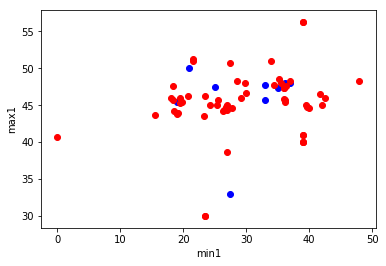

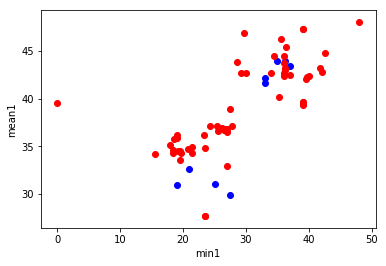

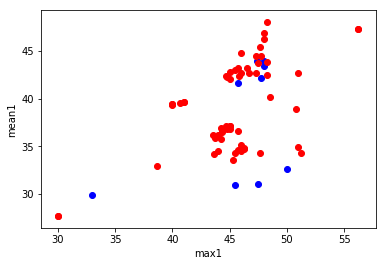

In [40]:
print("Time Series 1: ")
plt.xlabel("min1")
plt.ylabel("max1")
plt.scatter(min1_bending, max1_bending, color = 'b', marker = 'o')
plt.scatter(min1_etc, max1_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("min1")
plt.ylabel("mean1")
plt.scatter(min1_bending, mean1_bending, color = 'b', marker = 'o')
plt.scatter(min1_etc, mean1_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("max1")
plt.ylabel("mean1")
plt.scatter(max1_bending, mean1_bending, color = 'b', marker = 'o')
plt.scatter(max1_etc, mean1_etc, color = 'r', marker = 'o')
plt.show()

Time Series 2: 


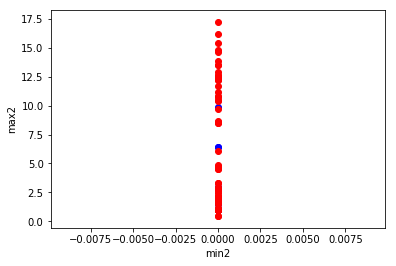

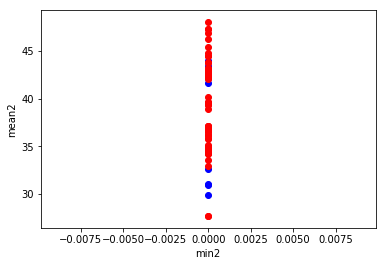

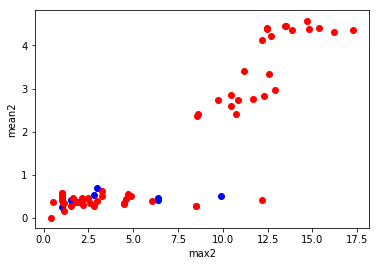

In [41]:
print("Time Series 2: ")
plt.xlabel("min2")
plt.ylabel("max2")
plt.scatter(min2_bending, max2_bending, color = 'b', marker = 'o')
plt.scatter(min2_etc, max2_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("min2")
plt.ylabel("mean2")
plt.scatter(min2_bending, mean1_bending, color = 'b', marker = 'o')
plt.scatter(min2_etc, mean1_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("max2")
plt.ylabel("mean2")
plt.scatter(max2_bending, mean2_bending, color = 'b', marker = 'o')
plt.scatter(max2_etc, mean2_etc, color = 'r', marker = 'o')
plt.show()

Time Series 6: 


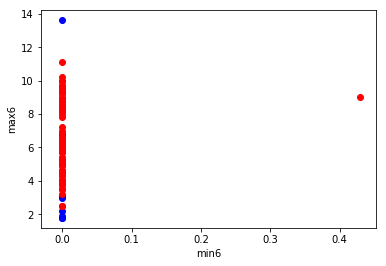

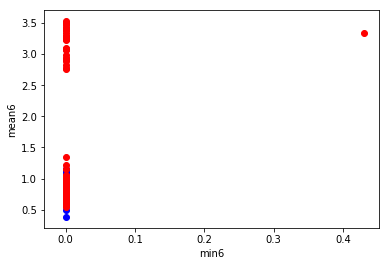

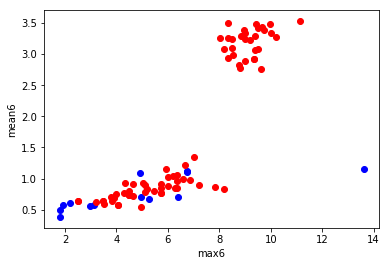

In [27]:
print("Time Series 6: ")
plt.xlabel("min6")
plt.ylabel("max6")
plt.scatter(min6_bending, max6_bending, color = 'b', marker = 'o')
plt.scatter(min6_etc, max6_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("min6")
plt.ylabel("mean6")
plt.scatter(min6_bending, mean6_bending, color = 'b', marker = 'o')
plt.scatter(min6_etc, mean6_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("max6")
plt.ylabel("mean6")
plt.scatter(max6_bending, mean6_bending, color = 'b', marker = 'o')
plt.scatter(max6_etc, mean6_etc, color = 'r', marker = 'o')
plt.show()

In [70]:
def data_time_domain(dataframe): 
    newtrain = []
    for ds in dataframe:
        df = ds[0]
        stats = df.describe()
        stats = stats.loc[['min','max','mean','50%','std','25%','75%']]
        row = pd.Series()
        for i in range(1, 7):
            row['min'+str(i)] = stats.iloc[0,i]
            row['max'+str(i)] = stats.iloc[1,i]
            row['mean'+str(i)] = stats.iloc[2,i]
            row['median'+str(i)] = stats.iloc[3,i]
            row['std'+str(i)] = stats.iloc[4,i]
            row['1st_quart'+str(i)] = stats.iloc[5,i]
            row['3rd_quart'+str(i)] = stats.iloc[6,i]
        row['activity'] = ds[1]
        newtrain.append(row)
    newtrain = pd.DataFrame(newtrain)
    return newtrain


original_train = data_time_domain(train_data2)
original_test = data_time_domain(test_data2)
# encode into 0 or 1 
original_train['bending'] = np.where(np.logical_or((original_train.activity == 'bending1'), (original_train.activity == 'bending2')), 0, 1) 
original_train_binary = original_train.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
y_train = original_train_binary['bending']


# encode into 0 or 1 
original_test['bending'] = np.where(np.logical_or((original_test.activity == 'bending1'), (original_test.activity == 'bending2')), 0, 1) 
original_test_binary = original_test.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_test = pd.DataFrame(original_test_binary, columns = original_test_binary.columns[:-1])
y_test = original_test_binary['bending']

In [71]:
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print("Accuracy: " + str(score))
y_pred = logisticRegr.predict(x_test)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
Confusion matrix:
[[ 4  0]
 [ 0 15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        15

   micro avg       1.00      1.00      1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



ii. Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the 88 instances, you have 12 time series for each instance. Repeat the experiment in 1(d)i. Do you see any considerable difference in the results with those of 1(d)i?

In [46]:
splitted = [] 
for train in train_data2: 
    df1 = train[0][:240]
    df2 = train[0][240:]
    splitted.append((df1, train[1]))
    splitted.append((df2, train[1]))
    
split_read = []
for ds in splitted:
    df = ds[0]
    stats = df.describe()
    stats = stats.loc[['min','max','mean','50%','std','25%','75%']]
    row = pd.Series()
    for i in range(1, 7):
        row['min'+str(i)] = stats.iloc[0,i]
        row['max'+str(i)] = stats.iloc[1,i]
        row['mean'+str(i)] = stats.iloc[2,i]
        row['median'+str(i)] = stats.iloc[3,i]
        row['std'+str(i)] = stats.iloc[4,i]
        row['1st_quart'+str(i)] = stats.iloc[5,i]
        row['3rd_quart'+str(i)] = stats.iloc[6,i]
    row['activity'] = ds[1]
    split_read.append(row)
    
split_read = pd.DataFrame(split_read)
split_read

min1   max1      mean1  median1      std1  1st_quart1  3rd_quart1  min2  \
0    36.50  46.50  44.057167   44.500  1.556971     43.2500     45.0000  0.00   
1    35.00  47.40  43.851833   43.500  1.557168     43.0000     45.0000  0.00   
2    33.75  47.75  43.278875   45.000  3.473355     42.0000     45.2500  0.00   
3    33.00  46.00  41.080750   42.000  3.537481     37.7500     44.5000  0.00   
4    33.00  45.75  41.621208   42.330  3.118644     39.6525     44.2500  0.00   
5    39.25  43.67  41.734917   41.500  0.595920     41.5000     42.0000  0.00   
6    39.00  48.00  44.117042   45.000  1.359836     43.5000     45.0000  0.00   
7    37.00  46.50  42.792875   42.670  1.058792     42.5000     43.0000  0.00   
8    36.67  45.00  43.486208   43.710  1.281976     42.3300     44.5000  0.00   
9    36.25  48.00  44.452042   44.500  1.771251     44.2500     44.7500  0.00   
10   21.00  50.00  32.014375   26.125  8.743464     24.7300     42.0000  0.00   
11   27.00  36.00  33.158042   33.000  0.941701     33.0000     33.7500  0.00   
12   29.00  33.00  30.712417   30.290  0.937965     30.0000     31.5000  0.00   
13   27.50  30.00  29.051458   29.000  0.635067     28.6700     29.5000  0.00   
14   19.00  39.25  29.189875   27.000  6.216895     25.9375     36.0000  0.00   
15   20.00  45.50  32.686333   30.000  8.576204     27.0000     42.0000  0.00   
16   25.00  47.50  34.110625   30.500  5.097232     30.0000     39.3725  0.00   
17   25.00  33.00  28.005875   27.585  1.434469     27.0000     29.0000  0.00   
18   26.00  44.00  36.183208   35.750  3.324873     34.0000     38.8125  0.00   
19   19.00  44.00  36.273583   36.000  3.727665     33.7500     39.2500  0.00   
20   28.00  43.33  36.517542   36.000  3.305618     34.2500     39.0000  0.00   
21   26.50  44.33  36.857042   36.000  3.739054     34.5000     39.7500  0.00   
22   27.80  44.67  37.069917   36.250  3.822253     34.5000     40.2700  0.00   
23   25.33  45.00  37.158708   36.250  3.602490     35.0000     40.0625  0.00   
24   26.75  44.50  36.830792   36.330  3.663132     34.6700     39.7500  0.00   
25   27.33  44.75  36.895958   36.250  3.452460     34.4750     39.8125  0.00   
26   26.25  43.40  36.865417   36.250  3.462793     34.3100     40.0000  0.00   
27   29.25  44.25  37.049500   36.415  3.411449     34.5000     40.2500  0.00   
28   27.75  44.00  37.144583   36.670  3.804785     34.0000     40.3300  0.00   
29   31.00  44.67  37.145083   36.250  3.720410     33.8100     40.5000  0.00   
..     ...    ...        ...      ...       ...         ...         ...   ...   
108  37.25  47.33  43.437458   44.125  1.809284     42.0000     44.7500  0.00   
109  36.00  45.00  41.911708   41.670  2.636281     39.5000     44.7500  0.00   
110  37.00  45.33  42.084750   43.125  2.690071     39.5000     45.0000  0.00   
111  36.25  45.75  44.290292   45.000  1.660985     44.5000     45.0000  0.00   
112  36.00  46.25  43.413042   45.000  2.584612     42.0000     45.0000  0.00   
113  37.75  47.33  45.469333   45.750  1.706665     45.0000     46.5000  0.00   
114  18.00  45.67  35.236083   36.000  5.057973     31.7500     38.7500  0.00   
115  23.00  46.00  35.150583   35.625  4.434887     32.1875     38.5000  0.00   
116  22.33  46.00  34.966250   35.500  4.733014     32.0000     38.7500  0.00   
117  20.75  46.25  34.560417   35.000  4.752584     31.0000     37.7500  0.43   
118  21.50  45.67  34.737042   35.500  4.276717     32.0000     37.7500  0.00   
119  21.75  51.00  35.134583   35.585  4.989014     32.1875     38.3125  0.00   
120  18.33  45.00  33.886458   34.375  5.143776     30.4575     37.5000  0.00   
121  20.33  47.67  34.779625   35.000  4.714249     31.7300     38.2500  0.00   
122  18.33  44.00  34.836458   35.750  4.869092     32.0000     38.6900  0.00   
123  22.67  45.75  34.363292   35.000  4.588342     31.4575     37.5000  0.00   
124  23.00  42.75  34.329333   34.710  4.549837     31.3100     37.5425  0.00   
125  15.50  43.67  34.122417   34.750

In [47]:
newData2 = split_read

bending1 = newData2.loc[newData2['activity'] == 'bending1']
bending2 = newData2.loc[newData2['activity'] == 'bending2']

cycling = newData2.loc[newData2['activity'] == 'cycling']
lying = newData2.loc[newData2['activity'] == 'lying']
sitting = newData2.loc[newData2['activity'] == 'sitting']
standing = newData2.loc[newData2['activity'] == 'standing']
walking = newData2.loc[newData2['activity'] == 'walking']

bending_all = bending1.append(bending2)
#cycling + lying + sitting + standing + walking
etc = cycling.append(lying)
etc = etc.append(sitting)
etc = etc.append(standing)
etc = etc.append(walking)

# Time Series 1
min1_bending = list(bending_all['min1'])
min1_etc = list(etc['min1'])

max1_bending = list(bending_all['max1'])
max1_etc = list(etc['max1'])    

mean1_bending = list(bending_all['mean1'])
mean1_etc = list(etc['mean1'])    

# Time Series 2
min2_bending = list(bending_all['min2'])
min2_etc = list(etc['min2'])

max2_bending = list(bending_all['max2'])
max2_etc = list(etc['max2'])    

mean2_bending = list(bending_all['mean2'])
mean2_etc = list(etc['mean2'])    

# Time Series 6
min6_bending = list(bending_all['min6'])
min6_etc = list(etc['min6'])

max6_bending = list(bending_all['max6'])
max6_etc = list(etc['max6'])    

mean6_bending = list(bending_all['mean6'])
mean6_etc = list(etc['mean6'])   

Time Series 1: 


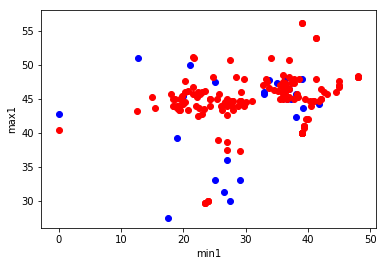

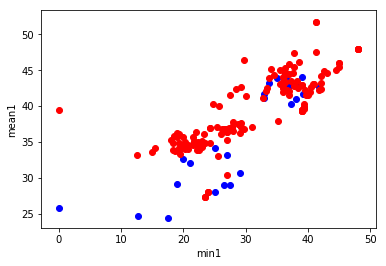

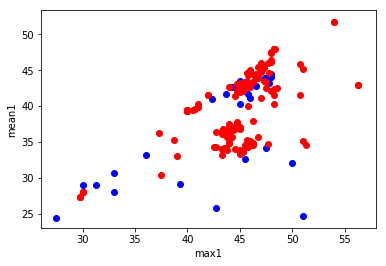

In [33]:
print("Time Series 1: ")
plt.xlabel("min1")
plt.ylabel("max1")
plt.scatter(min1_bending, max1_bending, color = 'b', marker = 'o')
plt.scatter(min1_etc, max1_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("min1")
plt.ylabel("mean1")
plt.scatter(min1_bending, mean1_bending, color = 'b', marker = 'o')
plt.scatter(min1_etc, mean1_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("max1")
plt.ylabel("mean1")
plt.scatter(max1_bending, mean1_bending, color = 'b', marker = 'o')
plt.scatter(max1_etc, mean1_etc, color = 'r', marker = 'o')
plt.show()

Time Series 2: 


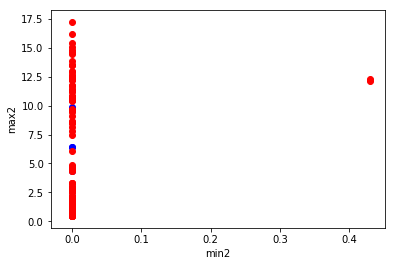

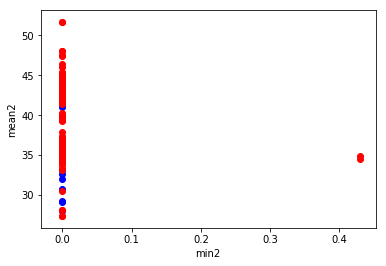

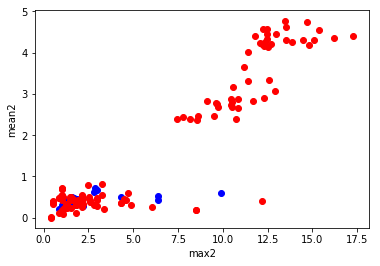

In [48]:
print("Time Series 2: ")
plt.xlabel("min2")
plt.ylabel("max2")
plt.scatter(min2_bending, max2_bending, color = 'b', marker = 'o')
plt.scatter(min2_etc, max2_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("min2")
plt.ylabel("mean2")
plt.scatter(min2_bending, mean1_bending, color = 'b', marker = 'o')
plt.scatter(min2_etc, mean1_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("max2")
plt.ylabel("mean2")
plt.scatter(max2_bending, mean2_bending, color = 'b', marker = 'o')
plt.scatter(max2_etc, mean2_etc, color = 'r', marker = 'o')
plt.show()

Time Series 6: 


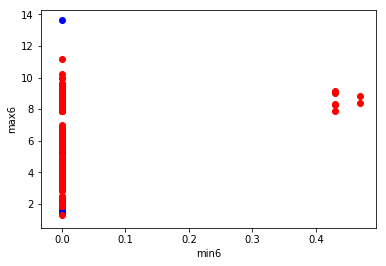

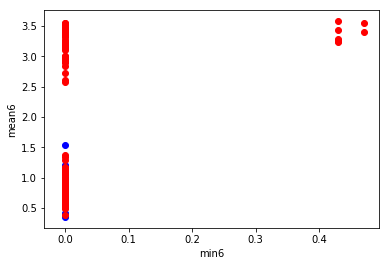

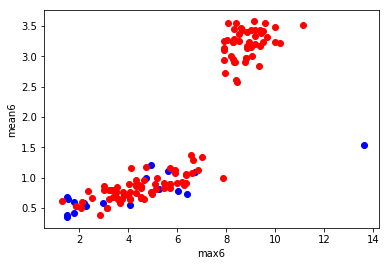

In [49]:
print("Time Series 6: ")
plt.xlabel("min6")
plt.ylabel("max6")
plt.scatter(min6_bending, max6_bending, color = 'b', marker = 'o')
plt.scatter(min6_etc, max6_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("min6")
plt.ylabel("mean6")
plt.scatter(min6_bending, mean6_bending, color = 'b', marker = 'o')
plt.scatter(min6_etc, mean6_etc, color = 'r', marker = 'o')
plt.show()

plt.xlabel("max6")
plt.ylabel("mean6")
plt.scatter(max6_bending, mean6_bending, color = 'b', marker = 'o')
plt.scatter(max6_etc, mean6_etc, color = 'r', marker = 'o')
plt.show()

In [60]:
# function to split dataset into l time series of approximately equal length 
def split_data(dataframe, split_factor):
    splitted = [] 
    for train in dataframe: 
        preprocessing_split_df = train[0]
        equal_split_list = np.array_split(preprocessing_split_df, split_factor) 
        for i in range(len(equal_split_list)): 
            splitted.append((equal_split_list[i], train[1]))
    
    split_read = []
    for ds in splitted:
        df = ds[0]
        stats = df.describe()
        stats = stats.loc[['min','max','mean','50%','std','25%','75%']]
        row = pd.Series()
        for i in range(1, 7):
            row['min'+str(i)] = stats.iloc[0, i]
            row['max'+str(i)] = stats.iloc[1, i]
            row['mean'+str(i)] = stats.iloc[2, i]
            row['median'+str(i)] = stats.iloc[3, i]
            row['std'+str(i)] = stats.iloc[4, i]
            row['1st_quart'+str(i)] = stats.iloc[5, i]
            row['3rd_quart'+str(i)] = stats.iloc[6, i]
        row['activity'] = ds[1]
        split_read.append(row)
        
    split_read = pd.DataFrame(split_read)
    return split_read

In [65]:
split2_train = split_data(train_data2, 2)
#split2_test = split_data(test_data2, 2)

original_train = split2_train
#original_test = split2_test
# encode into 0 or 1 
original_train['bending'] = np.where(np.logical_or((original_train.activity == 'bending1'), (original_train.activity == 'bending2')), 0, 1) 
original_train_binary = original_train.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
y_train = original_train_binary['bending']

logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
score = logisticRegr.score(x_test, y_test)
print("Accuracy: " + str(score))
y_pred = logisticRegr.predict(x_test)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 1.0
Confusion matrix:
[[ 4  0]
 [ 0 15]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00        15

   micro avg       1.00      1.00      1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19



- The test error is 0 for bth i) and ii) and an accuracy of 100%. However, usually splitting the data is recommended as splitting can modify the features. It treats the whole data as two new data sets which can lead to better training of the model, and usually as we have more training examples, the better the model. 

iii. Break each time series in your training set into l ∈ {1, 2, . . . , 20} time series of approximately equal length and use logistic regression to solve the binary classification problem, using time-domain features. Calculate the p-values for your logistic regression parameters and refit a logistic regression model using your pruned set of features. Alternatively, you can use backward selection using sklearn.feature selection or glm in R. Use 5-fold cross-validation to determine the best value of l. Explain what the right way and the wrong way are to perform cross-validation in this problem.6 Obviously, use the right way! Also, you may encounter the problem of class imbalance, which may make some of your folds not having any instances of the rare class. In such a case, you can use stratified cross validation. Research what it means and use it if needed.

In [74]:
# https://gist.github.com/rspeare/77061e6e317896be29c6de9a85db301d
# found an online logistic regression class that calculates p-values 

from sklearn import linear_model
import numpy as np
import scipy.stats as stat

class LogisticReg:
    """
    Wrapper Class for Logistic Regression which has the usual sklearn instance 
    in an attribute self.model, and pvalues, z scores and estimated 
    errors for each coefficient in 
    
    self.z_scores
    self.p_values
    self.sigma_estimates
    
    as well as the negative hessian of the log Likelihood (Fisher information)
    
    self.F_ij
    """
    
    def __init__(self,*args,**kwargs):#,**kwargs):
        self.model = linear_model.LogisticRegression(*args,**kwargs)#,**args)

    def fit(self,X,y):
        self.model.fit(X,y)
        #### Get p-values for the fitted model ####
        denom = (2.0*(1.0+np.cosh(self.model.decision_function(X))))
        denom = np.tile(denom,(X.shape[1],1)).T
        F_ij = np.dot((X/denom).T,X) ## Fisher Information Matrix
        Cramer_Rao = np.linalg.inv(F_ij) ## Inverse Information Matrix
        sigma_estimates = np.array([np.sqrt(Cramer_Rao[i,i]) for i in range(Cramer_Rao.shape[0])]) # sigma for each coefficient
        z_scores = self.model.coef_[0]/sigma_estimates # z-score for eaach model coefficient
        p_values = [stat.norm.sf(abs(x))*2 for x in z_scores] ### two tailed test for p-values
        
        self.z_scores = z_scores
        self.p_values = p_values
        self.sigma_estimates = sigma_estimates
        self.F_ij = F_ij

In [75]:
cv_accuracy = [] 
feature_sets = []
feature_nums = []
for k in range(1, 21): 
    train = split_data(train_data2, k)
    original_train = train
    
    # encode into 0 or 1 
    original_train['bending'] = np.where(np.logical_or((original_train.activity == 'bending1'), (original_train.activity == 'bending2')), 0, 1) 
    original_train_binary = original_train.drop('activity', axis = 1)
    # split the dataset into feature vector and a label vector 
    x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
    y_train = original_train_binary['bending']
    logisticR = LogisticRegression()
    
    rfecv = RFECV(estimator=logisticR, step=1, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=9), scoring='accuracy')
    rfecv.fit(x_train, y_train)
    cv_accuracy.append(max(rfecv.grid_scores_))
    selected_indices = np.argwhere(rfecv.support_==True).flatten() 
    feature_sets.append(selected_indices)
    feature_nums.append(rfecv.n_features_)    

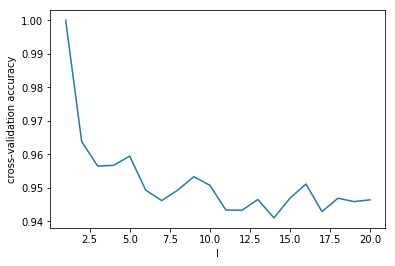

The best value of l is 1 and the best cross validation accuracy is 1.0
When l = 1, we selecte 8 features, and they are ['mean1', '3rd_quart1', 'max2', 'median3', 'min5', 'max5', 'mean5', '1st_quart5']


In [107]:
plt.plot(range(1,21), cv_accuracy)
plt.xlabel('l')
plt.ylabel('cross-validation accuracy')
plt.show()

l_best = np.argmax(cv_accuracy) + 1
best_accuracy = max(cv_accuracy)
print("The best value of l is " + str(l_best) + " and the best cross validation accuracy is " + str(best_accuracy))

selected_indices = feature_sets[0]
selected = []
for i in selected_indices:
    selected.append(features[i])
print("When l = 1, we selecte " + str(len(selected)) + " features, and they are " + str(selected))

- In this part, backward selection from sklearn.feature_selection was used to select the features. 
- The correct way to use cross validation is using backward selection for each value of l, using corss validation accuracy to select the features and then selecting l with the highest cross validation accuracy. Thus, cross validation has to occur on both l and for feature selection 
- The wrong way to use cross validation is only using cross validation to choose l but not using cross validation for feature selection. Thus, cross validation must be used to select the best feature sets for each l. 

iv. Report the confusion matrix and show the ROC and AUC for your classifier on train data. Report the parameters of your logistic regression βi’s as well as the p-values associated with them.

Confusion matrix:
[[ 9  0]
 [ 0 60]]


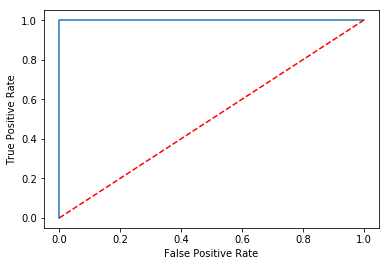

Area under the curve is 1.0


In [179]:
split2_train = split_data(train_data2, 1)
split2_test = split_data(test_data2, 1)

original_train = split2_train
original_test = split2_test
# encode into 0 or 1 
original_train['bending'] = np.where(np.logical_or((original_train.activity == 'bending1'), (original_train.activity == 'bending2')), 0, 1) 
original_train_binary = original_train.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
y_train = original_train_binary['bending']

# encode into 0 or 1 
original_test['bending'] = np.where(np.logical_or((original_test.activity == 'bending1'), (original_test.activity == 'bending2')), 0, 1) 
original_test_binary = original_test.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_test = pd.DataFrame(original_test_binary, columns = original_test_binary.columns[:-1])
y_test = original_test_binary['bending']

logit = LogisticRegression()
logit.fit(x_train, y_train)
y_pred = logit.predict(x_train)

print("Confusion matrix:")
print(metrics.confusion_matrix(y_train, y_pred))

fpr, tpr, thresh = roc_curve(y_train, y_pred)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

auc = roc_auc_score(y_train, y_pred)
print("Area under the curve is " + str(auc))

In [165]:
logitReg = LogisticReg()
x_train = x_train.iloc[:, selected_indices]
logitReg.fit(x_train, y_train)

df = pd.DataFrame()
df['coefficient'] = classifier.coef_.flatten()
df['p-values'] = logitReg.p_values
df.index = selected 
df

coefficient  p-values
mean1          0.308439  0.827577
3rd_quart1     0.384309  0.812175
max2           0.409483  0.540287
median3        0.226237  0.749297
min5          -0.439377  0.661229
max5          -0.645561  0.450377
mean5         -0.280896  0.961755
1st_quart5    -0.308685  0.943100

v. Test the classifier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classifier has to be tested using the features
extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [166]:
# since l = 1, no need to break the time series 

x_test = x_test.iloc[:, selected_indices]

logit = LogisticRegression()
logit.fit(x_train, y_train)
y_pred = logit.predict(x_test)
print("Test Accuracy: " + str(metrics.accuracy_score(y_test, y_pred)))

Test Accuracy: 1.0


- Thus, the accuray on the test set and the accuracy of the cross-validation for l = 2, is the same (1.0 for both)

vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

- Yes, in fact when trying to run the code below by deleting the comments for the last line, we get PerfectSeparationError... 

In [121]:
import statsmodels.api as sm
x_train = x_train.iloc[:, selected_indices]
model = sm.Logit(y_train, x_train)
# result = model.fit(). PerfectSeparationError: Perfect separation detected, results not available

vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

- Yes, there is class imbalance, and we fix it below 

Confusion matrix:
[[4 0]
 [0 4]]


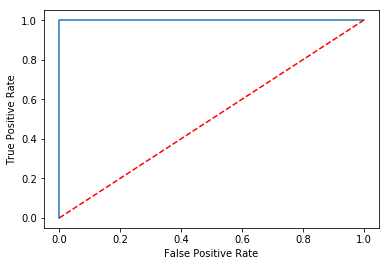

Area under the curve is 1.0


In [182]:
from imblearn.under_sampling import RandomUnderSampler

split2_train = split_data(train_data2, 1)
split2_test = split_data(test_data2, 1)

original_train = split2_train
original_test = split2_test
# encode into 0 or 1 
original_train['bending'] = np.where(np.logical_or((original_train.activity == 'bending1'), (original_train.activity == 'bending2')), 0, 1) 
original_train_binary = original_train.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
y_train = original_train_binary['bending']

# encode into 0 or 1 
original_test['bending'] = np.where(np.logical_or((original_test.activity == 'bending1'), (original_test.activity == 'bending2')), 0, 1) 
original_test_binary = original_test.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_test = pd.DataFrame(original_test_binary, columns = original_test_binary.columns[:-1])
y_test = original_test_binary['bending']


rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(x_test, y_test)

X=X_resampled = pd.DataFrame(X_resampled)
y=y_resampled = pd.DataFrame(y_resampled)


logit = LogisticRegression()
logit.fit(x_train, y_train)
y_pred = logit.predict(X)

print("Confusion matrix:")
print(metrics.confusion_matrix(y, y_pred))

fpr, tpr, thresh = roc_curve(y, y_pred)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

auc = roc_auc_score(y, y_pred)
print("Area under the curve is " + str(auc))

(e) Binary Classification Using L1-penalized logistic regression

i. Repeat 1(d)iii using L1-penalized logistic regression, i.e. instead of using p-values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.

In [183]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

print("values of C used for cross validation:")
c_vals = np.append(np.logspace(-10,-1,10),np.arange(0.1, 1, 0.1))
c_vals = np.append(c_vals, range(1,10))
c_vals = np.append(c_vals, np.logspace(1,10,10))
print(c_vals)

values of C used for cross validation:
[  1.00000000e-10   1.00000000e-09   1.00000000e-08   1.00000000e-07
   1.00000000e-06   1.00000000e-05   1.00000000e-04   1.00000000e-03
   1.00000000e-02   1.00000000e-01   1.00000000e-01   2.00000000e-01
   3.00000000e-01   4.00000000e-01   5.00000000e-01   6.00000000e-01
   7.00000000e-01   8.00000000e-01   9.00000000e-01   1.00000000e+00
   2.00000000e+00   3.00000000e+00   4.00000000e+00   5.00000000e+00
   6.00000000e+00   7.00000000e+00   8.00000000e+00   9.00000000e+00
   1.00000000e+01   1.00000000e+02   1.00000000e+03   1.00000000e+04
   1.00000000e+05   1.00000000e+06   1.00000000e+07   1.00000000e+08
   1.00000000e+09   1.00000000e+10]


In [188]:
best_Cs = []
cv_scores = []
for l in range(1, 21):
    train = split_data(train_data2, l)
    original_train = train
    
    # encode into 0 or 1 
    original_train['bending'] = np.where(np.logical_or((original_train.activity == 'bending1'), (original_train.activity == 'bending2')), 0, 1) 
    original_train_binary = original_train.drop('activity', axis = 1)
    # split the dataset into feature vector and a label vector 
    x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
    y_train = original_train_binary['bending']
    
    #standardize features
    x_train = preprocessing.scale(x_train)
    
    logit_l1 = LogisticRegression(penalty='l1', solver='liblinear')
    param_grid = {'C': c_vals}
    clf = GridSearchCV(logit_l1, param_grid, cv=StratifiedKFold(5), scoring='accuracy')
    clf.fit(x_train, y_train)
    best_Cs.append(clf.best_params_["C"])
    cv_scores.append(clf.best_score_)

In [189]:
best_l = np.argmax(cv_scores)+1
best_c = best_Cs[best_l-1]
print("The best value of l is " + str(best_l) + ", and its corresponding best C is " + str(best_c))

The best value of l is 1, and its corresponding best C is 0.3


In [192]:
train = split_data(train_data2, 1)
original_train = train
    
# encode into 0 or 1 
original_train['bending'] = np.where(np.logical_or((original_train.activity == 'bending1'), (original_train.activity == 'bending2')), 0, 1) 
original_train_binary = original_train.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
y_train = original_train_binary['bending']
#standardize features
x_train = preprocessing.scale(x_train)

test = split_data(test_data2, 1)
original_test = test

# encode into 0 or 1 
original_test['bending'] = np.where(np.logical_or((original_test.activity == 'bending1'), (original_test.activity == 'bending2')), 0, 1) 
original_test_binary = original_test.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_test = pd.DataFrame(original_test_binary, columns = original_test_binary.columns[:-1])
y_test = original_test_binary['bending']
# standarize features 
x_test = preprocessing.scale(x_test)


#refit using the best C
clf = LogisticRegression(penalty='l1', solver='liblinear', C=0.3)
clf.fit(x_train, y_train)
print("Best Test accuracy for L1 Penalty (when l=1 and corresponding C = 0.3): " + str(clf.score(x_test, y_test)))

Best Test accuracy for L1 Penalty (when l=1 and corresponding C = 0.3): 0.894736842105


ii. Compare the L1-penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

- Variable Selection using p-values (or since I used backward selection) gives better test accuracy. 
- However, it is easier to implement L1-penalized logistic regression since it is a callable sklearn library as opposed to variable selection using p-values, where sklearn does not explicitly gives p-values. 

(f) Multi-class Classification (The Realistic Case)

i. Find the best l in the same way as you found it in 1(e)i to build an L1-penalized multinomial regression model to classify all activities in your training set. Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.

In [194]:
activity_encoding = {a : i for i, a in enumerate(activities)}

best_Cs = []
cv_scores = []
for o in range(1, 21):
    train = split_data(train_data2, o)
    original_train = train
    
    original_train_binary = original_train.drop('activity', axis = 1)
    # split the dataset into feature vector and a label vector 
    x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
    y_train = original_train['activity'].apply(lambda a: activity_encoding[a])
    
    #standardize features
    x_train = preprocessing.scale(x_train)
    
    multi_logit = LogisticRegression(penalty='l1', tol=0.01, solver='saga', multi_class='multinomial')
    param_grid = {'C': c_vals}
    clf = GridSearchCV(multi_logit, param_grid, cv=StratifiedKFold(5), scoring='accuracy')
    clf.fit(x_train, y_train)
    best_Cs.append(clf.best_params_["C"])
    cv_scores.append(clf.best_score_)

In [195]:
best_l = np.argmax(cv_scores)+1
best_c = best_Cs[best_l-1]
print("The best value of l is " + str(best_l) + ", and its corresponding best C is " + str(best_c))

The best value of l is 1, and its corresponding best C is 0.7


In [216]:
train = split_data(train_data2, 1)
original_train = train

original_train_binary = original_train.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
y_train = original_train['activity'].apply(lambda a : activity_encoding[a])
#standardize features
x_train = preprocessing.scale(x_train)

test = split_data(test_data2, 1)
original_test = test

original_test_binary = original_test.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_test = pd.DataFrame(original_test_binary, columns = original_test_binary.columns[:-1])
y_test = original_test['activity'].apply(lambda a : activity_encoding[a])
# standarize features 
x_test = preprocessing.scale(x_test)


#refit using the best C
clf = LogisticRegression(penalty='l1', tol=0.01, solver='saga', multi_class='multinomial', C = 0.7)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print("Best Test Error for L1 Penalty (when l=1 and corresponding C = 0.7): " + str(1 - metrics.accuracy_score(y_test, y_pred)))

Best Test Error for L1 Penalty (when l=1 and corresponding C = 0.7): 0.0526315789474


In [217]:
print("Confusion matrix:")
metrics.confusion_matrix(y_test, y_pred)

Confusion matrix:


array([[2, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 1, 2, 0],
       [0, 0, 0, 0, 0, 0, 3]])

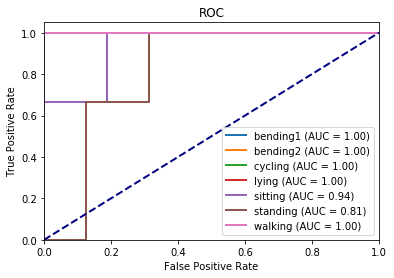

In [218]:
from sklearn.metrics import auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


clf = LogisticRegression(penalty='l1',tol=0.01,multi_class='multinomial', solver='saga', C=0.7)

y_train = label_binarize(y_train, classes=range(7))
y_test = label_binarize(y_test, classes=range(7))

clf = OneVsRestClassifier(clf)
score_y = clf.fit(x_train, y_train).decision_function(x_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], score_y[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=activities[i] + ' (AUC = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

ii. Repeat 1(f)i using a Naive Bayes’ classifier. Use both Gaussian and Multinomial priors and compare the results.

- (a) Gaussian Prior for Naive Bayes' Classifier

In [219]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score

In [214]:
cv_scores = [] 
for q in range(1, 21):
    train = split_data(train_data2, q)
    original_train = train
    
    original_train_binary = original_train.drop('activity', axis = 1)
    # split the dataset into feature vector and a label vector 
    x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
    y_train = original_train['activity'].apply(lambda a: activity_encoding[a])
    
    #standardize features
    x_train = preprocessing.scale(x_train)
    
    clf = GaussianNB()
    score = cross_val_score(clf, x_train, y_train, cv=5).mean()
    cv_scores.append(score)

In [220]:
best_l = np.argmax(cv_scores)+1
print("The best value of l is " + str(best_l))

The best value of l is 2


In [234]:
train = split_data(train_data2, 2)
original_train = train
    
original_train_binary = original_train.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
y_train = original_train['activity'].apply(lambda a : activity_encoding[a])

test = split_data(test_data2, 2)
original_test = test

original_test_binary = original_test.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_test = pd.DataFrame(original_test_binary, columns = original_test_binary.columns[:-1])
y_test = original_test['activity'].apply(lambda a : activity_encoding[a])

clf = GaussianNB()
clf.fit(x_train, y_train)
y_pred =  clf.predict(x_test)
print("Best Test error for " + str(1 - metrics.accuracy_score(y_test, y_pred)))

Best Test error for 0.105263157895


In [235]:
print("Confusion matrix:")
metrics.confusion_matrix(y_test, y_pred)

Confusion matrix:


array([[4, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0],
       [0, 0, 6, 0, 0, 0, 0],
       [0, 0, 0, 6, 0, 0, 0],
       [0, 0, 0, 1, 4, 1, 0],
       [0, 0, 0, 0, 2, 4, 0],
       [0, 0, 0, 0, 0, 0, 6]])

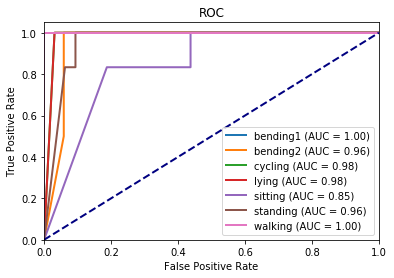

In [242]:
y_train = label_binarize(y_train, classes=range(7))
y_test = label_binarize(y_test, classes=range(7))
clf = GaussianNB()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    clf = clf.fit(x_train, y_train[:, i])
    y_score = clf.predict_proba(x_test)
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:,1])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=activities[i] + ' (AUC = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

- (b) Multinomial Prior for Naive Bayes' Classifier

In [244]:
cv_scores = [] 
for d in range(1, 21):
    train = split_data(train_data2, d)
    original_train = train
    
    original_train_binary = original_train.drop('activity', axis = 1)
    # split the dataset into feature vector and a label vector 
    x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
    y_train = original_train['activity'].apply(lambda a: activity_encoding[a])
    
    clf = MultinomialNB()
    score = cross_val_score(clf, x_train, y_train, cv=5).mean()
    cv_scores.append(score)

In [245]:
best_l = np.argmax(cv_scores)+1
print("The best value of l is " + str(best_l))

The best value of l is 1


In [252]:
train = split_data(train_data2, 1)
original_train = train
    
original_train_binary = original_train.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_train = pd.DataFrame(original_train_binary, columns = original_train_binary.columns[:-1])
y_train = original_train['activity'].apply(lambda a : activity_encoding[a])

test = split_data(test_data2, 1)
original_test = test

original_test_binary = original_test.drop('activity', axis = 1)
# split the dataset into feature vector and a label vector 
x_test = pd.DataFrame(original_test_binary, columns = original_test_binary.columns[:-1])
y_test = original_test['activity'].apply(lambda a : activity_encoding[a])

clf = MultinomialNB()
clf.fit(x_train, y_train)
y_pred =  clf.predict(x_test)
print("Best Test error for " + str(1 - metrics.accuracy_score(y_test, y_pred)))

Best Test error for 0.105263157895


In [253]:
print("Confusion matrix:")
metrics.confusion_matrix(y_test, y_pred)

Confusion matrix:


array([[2, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 0, 0, 0],
       [0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0],
       [0, 0, 0, 0, 2, 1, 0],
       [0, 0, 0, 1, 0, 2, 0],
       [0, 0, 0, 0, 0, 0, 3]])

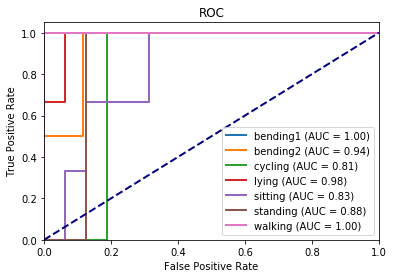

In [254]:
y_train = label_binarize(y_train, classes=range(7))
y_test = label_binarize(y_test, classes=range(7))
clf = MultinomialNB()

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(7):
    clf = clf.fit(x_train, y_train[:, i])
    y_score = clf.predict_proba(x_test)
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_score[:,1])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], lw=2, label=activities[i] + ' (AUC = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

iii. Which method is better for multi-class classification in this problem?

- If comparing the single best test error, L1-penalized multinomial regression seems to work the best as it has the lowest test error when l = 1. 
- When computing the average AUC for all classes, Multinomial has average AUC of 0.92, Gaussian has average AUC of 0.962, and L1-penalized has average AUC of 0.964. So, we can conlcude L1-penalized works the best. 

2.ISLR 3.7.4

- (a) Train RSS will be lower for cubic regression compared to linear since it will fit the train data better since it will have a smoother line because it can make a tighter fit against the train data that matched with a wider irreducible error. 
- (b) Test RSS for linear regression will be lower. Cubic regression will very likely overfit and not perform well on the test set, causing a higher Test RSS compared to the linear regression model. 
- (c) Cubic regression will have a lower Train RSS since no matter what the underlying true relationship between X and Y is, it is a more flexible model and will follow the training points more closer, reducing the Train RSS. 
- (d) There is not enough information about this question since the underlying true relationship is very vaguely defined: "not far from linear".  If the true model is closer to linear than cubic, the linear regression test RSS could be lower than the cubic regression test RSS, and vice versa. This is the variance-bias trade off as we are not clear which model with what flexibility fits the model better. 

3.ISLR, 4.7.3

In [255]:
from IPython.display import Image

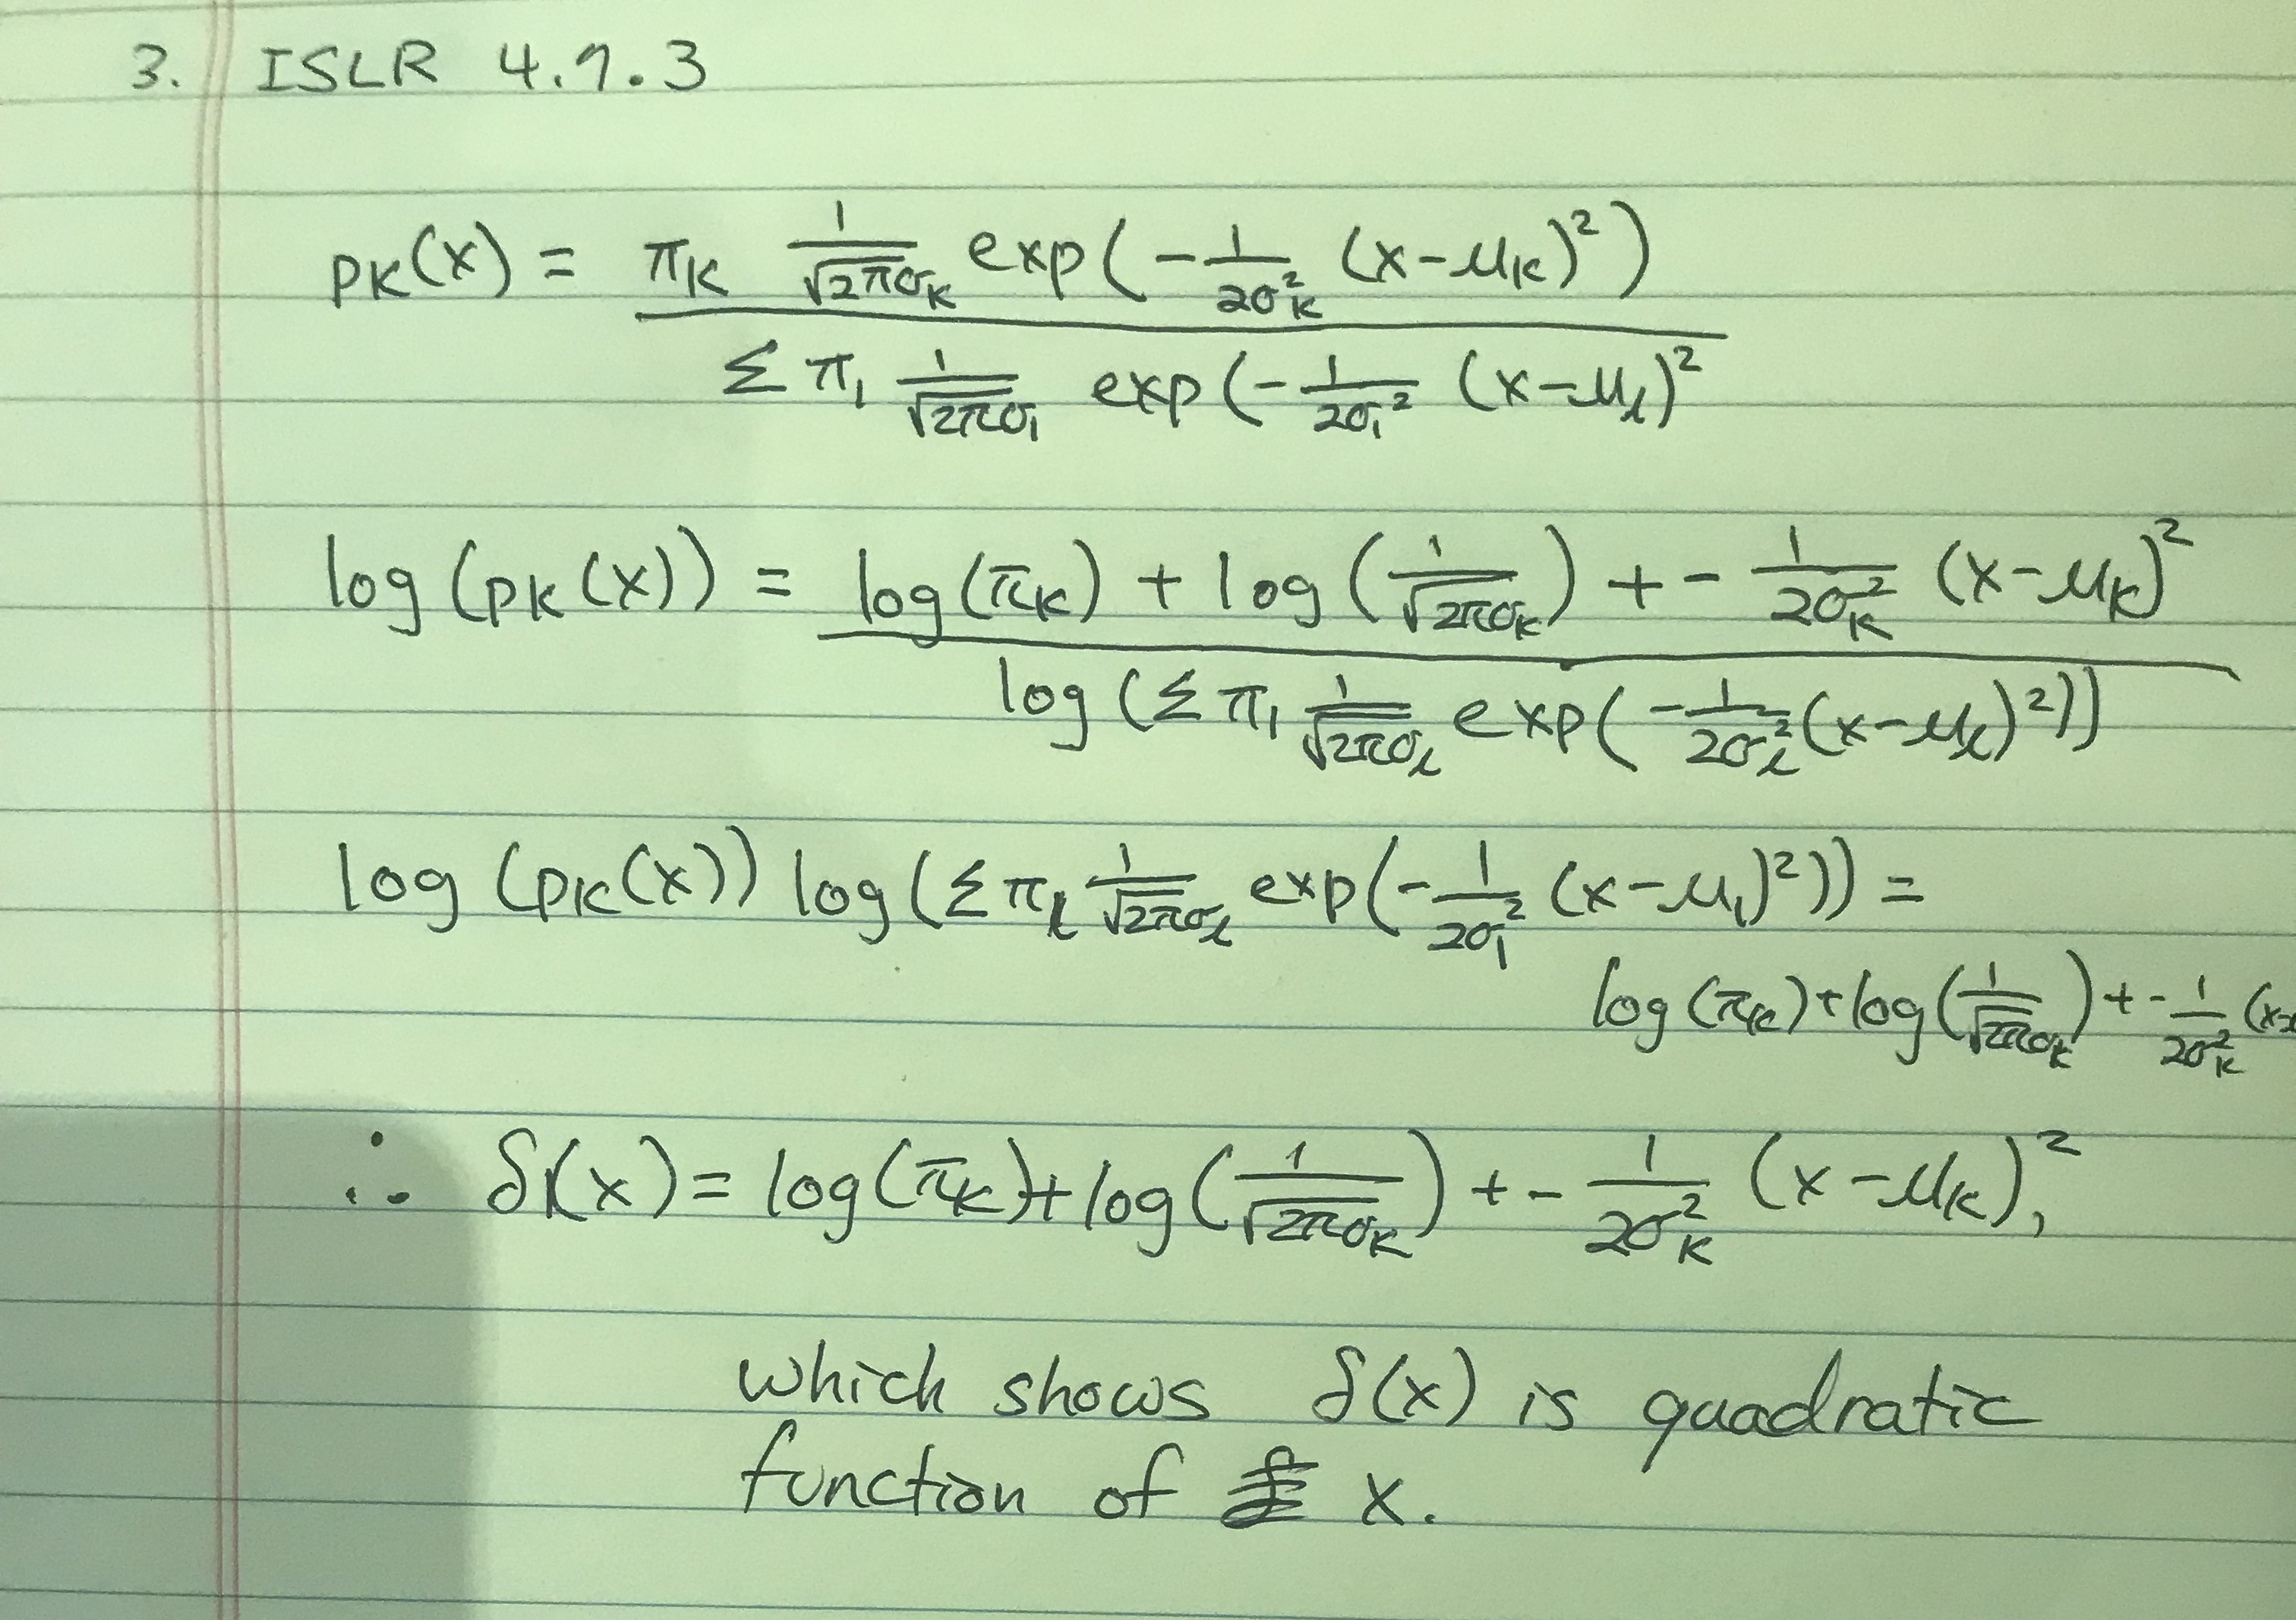

In [256]:
Image(filename='islr_473.jpg')

4.ISLR 4.7.7

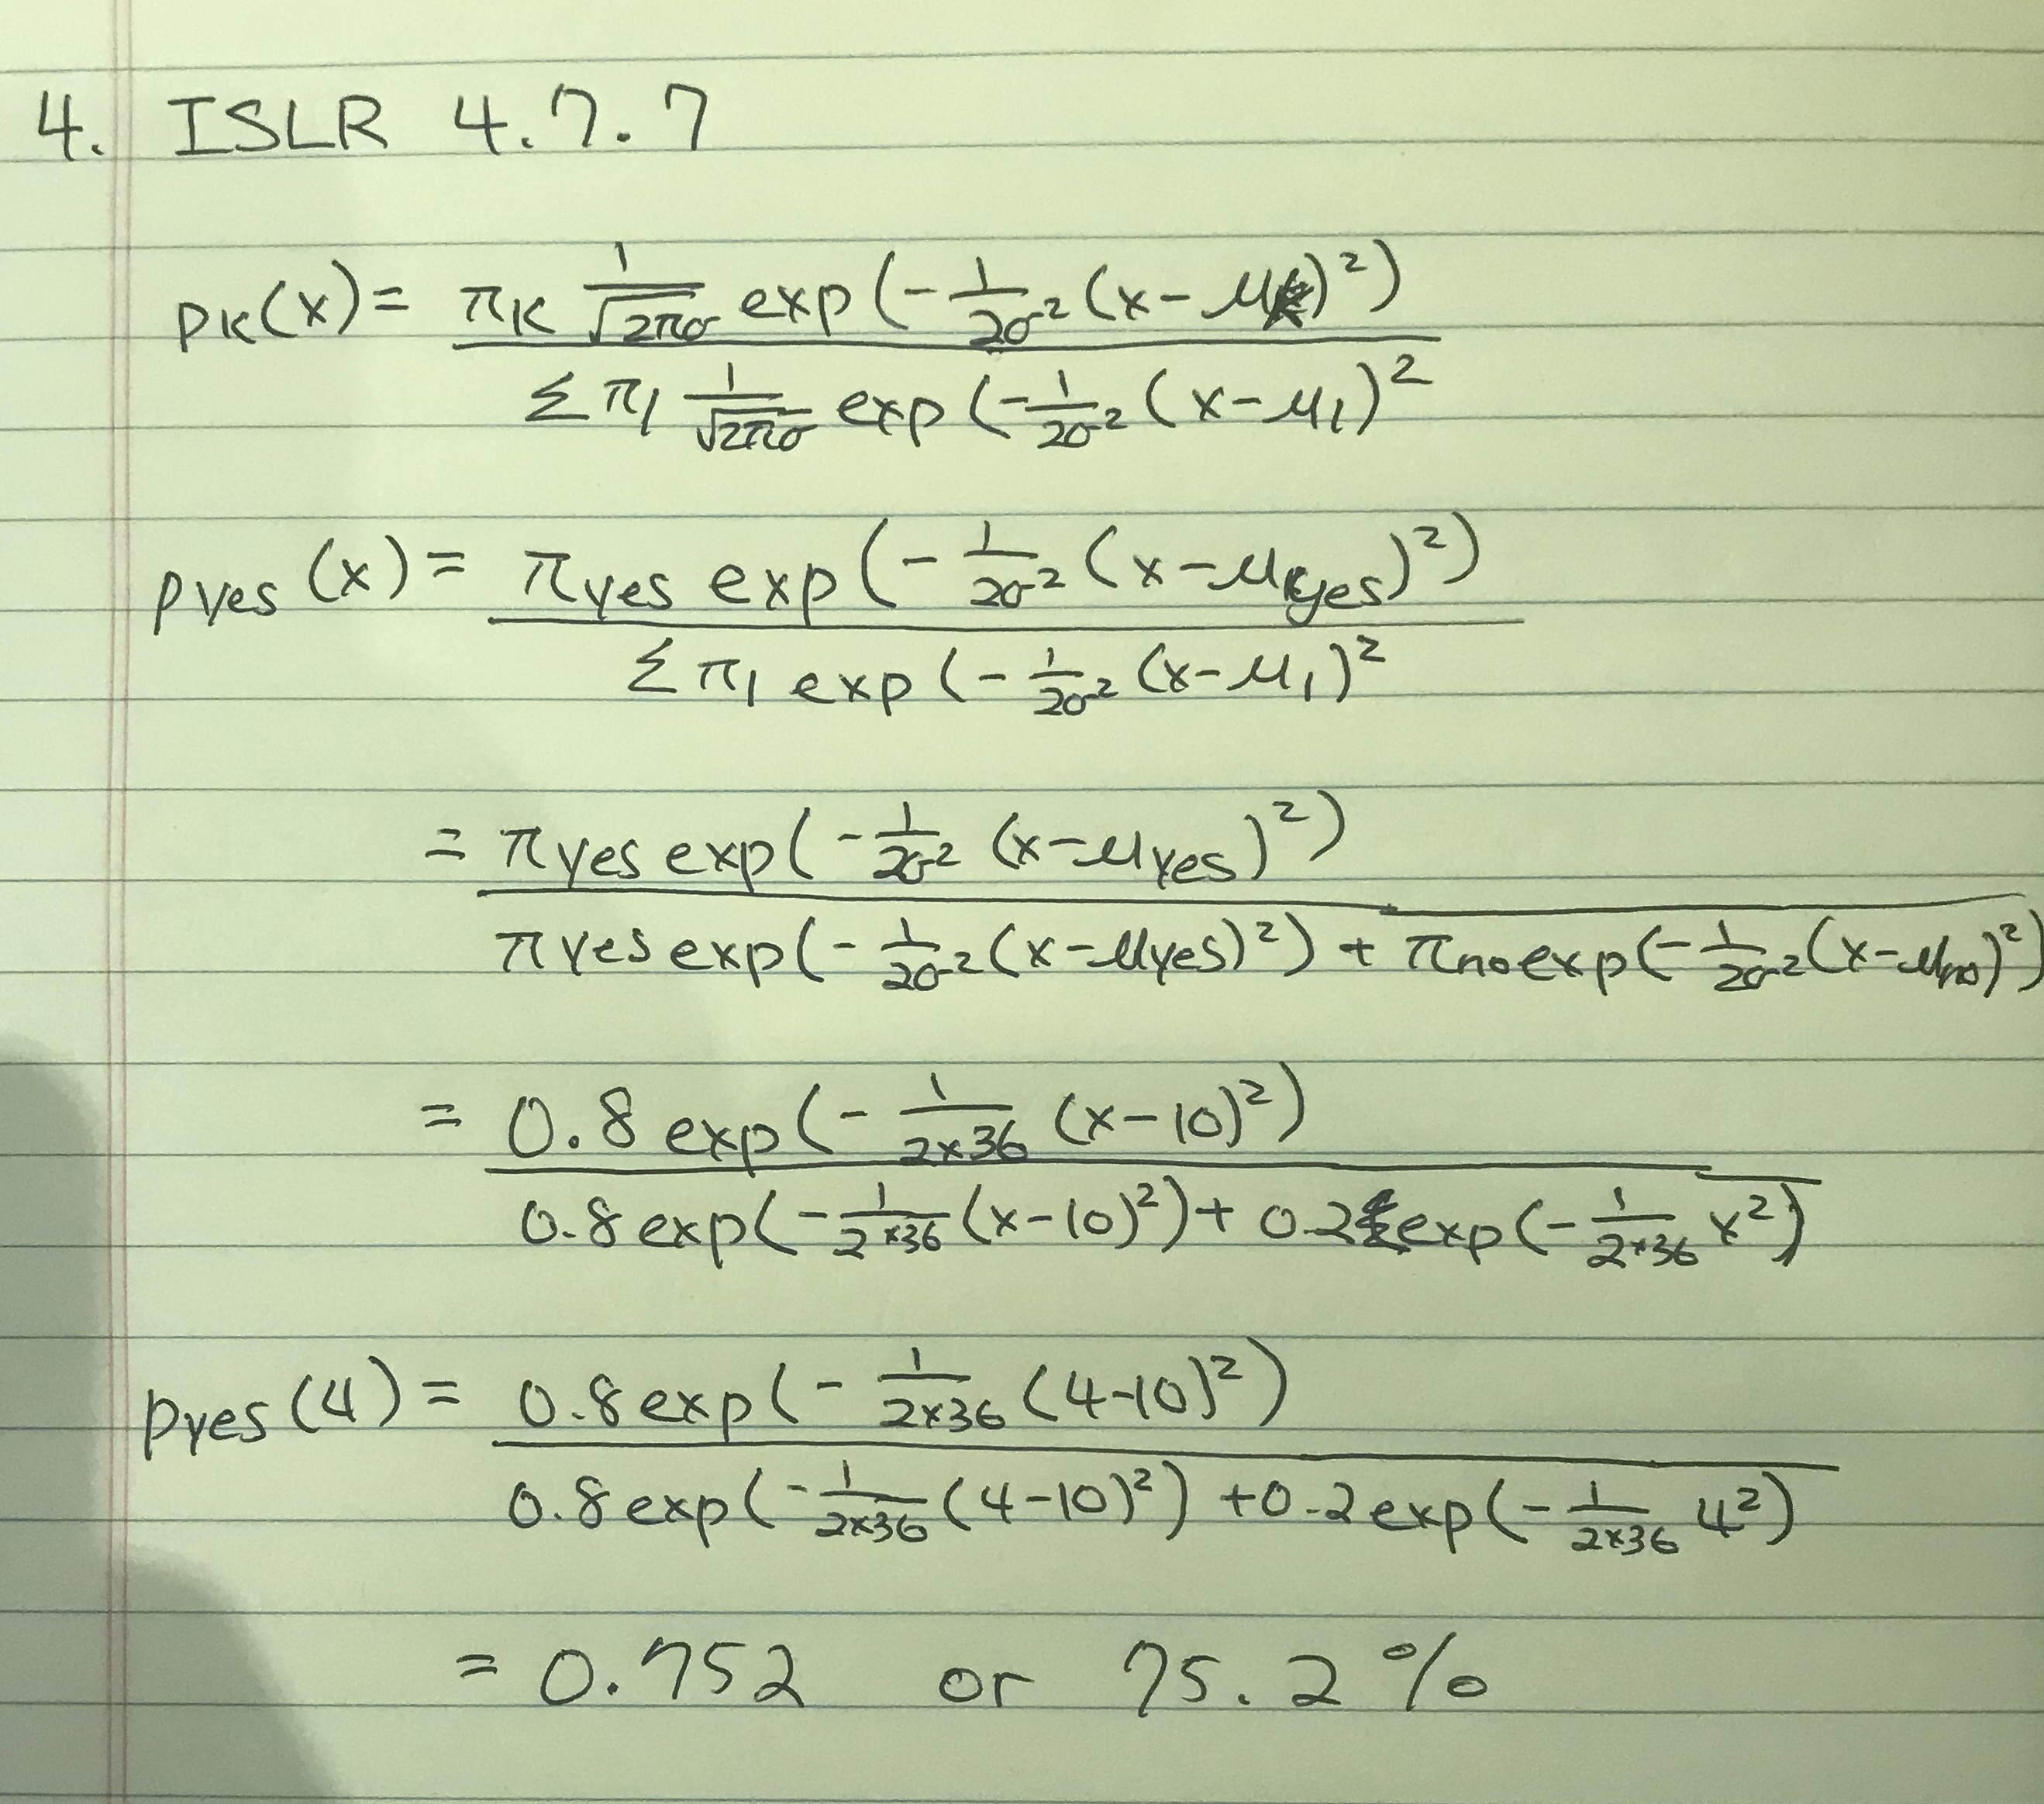

In [257]:
Image(filename='islr_477.jpg')